# Produce Original Handwritten Digits with a DCGAN
Architecture based on this [paper](https://arxiv.org/abs/1511.06434) and this [blog post](https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0), but is not as deep as either of these.



In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Build DCGAN Components

### Leaky Rectified Linear Unit
This will be the activation function for certain layers.

In [3]:
def lrelu(x):
    alpha = 0.2
    return tf.maximum(x,tf.multiply(x,alpha))

### Discriminator
CNN that attempts to determine whether the input is a 'fake' (generated) or 'real' (from MNIST) digit.

In [4]:
def discriminator(x, reuse=None):
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x = tf.layers.conv2d(x, filters=32, kernel_size=3, strides=1, padding='same')
        x = tf.layers.conv2d(x, filters=64, kernel_size=5, strides=2, padding='same')
        x = tf.layers.conv2d(x, filters=64, kernel_size=5, strides=2, padding='same',activation=lrelu)
        x = tf.layers.conv2d(x, filters=128, kernel_size=3, strides=1, padding='same',activation=lrelu)
        
        x = tf.contrib.layers.flatten(x)

        x = tf.layers.dense(x,units=100)
        x = tf.layers.dense(x,units=2,activation=tf.nn.tanh)
        
        return x

### Generator
Will generate digits in an attempt to trick the discriminator into believing it has generated a true MNIST digit.

In [5]:
def generator(x, reuse=None):
    with tf.variable_scope('generator', reuse=reuse):
        
        x = tf.layers.dense(x, units = 7*7*64)
        x = tf.reshape(x, [-1,7,7,64])
        
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=3, strides=1, padding='same',activation=lrelu)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=5, strides=2, padding='same')
        x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=5, strides=2, padding='same', activation=lrelu)
        x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=3, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.layers.conv2d_transpose(x, filters=1, kernel_size=3, strides=1, padding='same', activation=tf.nn.tanh)
        
        return x

## Build TensorFlow Graph

In [6]:
tf.reset_default_graph()
image = tf.placeholder(tf.float32, shape = [None, 28,28,1])
noise = tf.placeholder(tf.float32, shape = [None, 100])

#Generate a fake image from random noise
gen_image = generator(noise)
#Build two discriminators, one for real images and one to process the generated images
disc_real = discriminator(image)
#Reuse is set to true to use the variables generated from analyzing a real image
disc_fake = discriminator(gen_image, reuse=True)
disc_concat = tf.concat([disc_real, disc_fake], axis=0)

disc_goal = tf.placeholder(tf.int32, shape=[None])
gen_goal = tf.placeholder(tf.int32, shape=[None])

disc_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=disc_concat, labels=disc_goal))
gen_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=disc_fake, labels=gen_goal))

disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='discriminator')
gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')

disc_opt = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.4).minimize(disc_loss, var_list=disc_vars)
gen_opt = tf.train.AdamOptimizer(learning_rate=0.00033,beta1=0.55).minimize(gen_loss, var_list=gen_vars)

## Set Number of Epochs and Batch Size and Run Session

In [7]:
epochs = 15
batch_size = 16

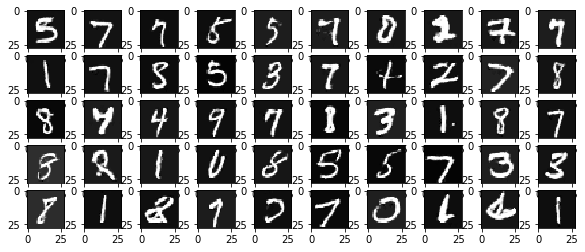

In [8]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    disc_losses = []
    gen_losses = []
    for epoch in range(epochs):
        #disc_losses = []
        #gen_losses = []
        batches = mnist.train.num_examples//batch_size
        for i in range(batches):
            batch_x, _ = mnist.train.next_batch(batch_size)
            batch_x = np.reshape(batch_x, newshape=[-1,28,28,1])
            z = np.random.uniform(-1., 1., size=[batch_size, 100])
            batch_disc_y=np.concatenate([np.ones([batch_size]),np.zeros([batch_size])], axis=0)
            batch_gen_y = np.ones([batch_size])
            
            feed_dict = {image: batch_x, noise: z, disc_goal: batch_disc_y, gen_goal: batch_gen_y}
            _, _, d_loss, g_loss = sess.run([disc_opt, gen_opt, disc_loss, gen_loss], feed_dict=feed_dict)
            
            disc_losses.append(d_loss)
            gen_losses.append(g_loss)
            
            #For troubleshooting/hyperparameter tuning
            #if i%500 == 0:
            #    print('Discriminant Loss: {:.4f} Generator Loss: {:.4f}'.format(d_loss,g_loss))
            
            
    #Plot example digits        
    fig, ax = plt.subplots(5, 10, figsize=(10, 4))
    for i in range(10):
        z = np.random.uniform(-1., 1., size=[5, 100])
        gen = sess.run(gen_image, feed_dict={noise: z})
        for j in range(5):
            img = np.reshape(gen[j], [28,28])
            ax[j][i].imshow(img, cmap='gray')
            
    plt.draw()